<a href="https://colab.research.google.com/github/senarkitbank/datasets/blob/main/Ugam_MultiLabel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from sklearn.svm import SVC

#### <font color="purple">**Import Packages / Setup** </font>

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import re
warnings.filterwarnings("ignore")

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB

In [4]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


#### <font color="purple">**Read Data** </font>

In [28]:
#df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/train.csv')
df = pd.read_csv('https://raw.githubusercontent.com/senarkitbank/datasets/main/Data/train_ugamnlp.csv')
# Read Test file
test = pd.read_csv('https://raw.githubusercontent.com/senarkitbank/datasets/main/Data/test_ugamnlp.csv')
print(df.columns)
df.head(2)

Index(['Id', 'Review', 'Components', 'Delivery and Customer Support',
       'Design and Aesthetics', 'Dimensions', 'Features', 'Functionality',
       'Installation', 'Material', 'Price', 'Quality', 'Usability',
       'Polarity'],
      dtype='object')


,Id,Review,Components,Delivery and Customer Support,Design and Aesthetics,Dimensions,Features,Functionality,Installation,Material,Price,Quality,Usability,Polarity
0,0,For some reason everybody complains and I'm co...,0,0,0,0,0,0,0,0,0,0,1,0
1,1,"I like everything about it, great choice of sp...",0,0,0,0,1,1,0,0,0,0,0,1


In [6]:
test_df = test.iloc[:,:2].set_index('Id')
print("Shape : ", test_df.shape)
test_df.head(2)

Shape :  (2631, 1)


,Review
Id,
0,Made of very thin cheap metal broke on very fi...
1,"As good as the brand names, no jams or misfire..."


#### <font color="green">**1. Number of Reviews in Each Category ?**</font>

In [7]:
df_tmp = df.drop(['Id','Review'], axis=1)
counts=[]
for i in list(df_tmp.columns.values):
    counts.append((i,df_tmp[i].sum()))

df_stats = pd.DataFrame(counts, columns=['Cateogry', 'Review_Count']).iloc[0:-1,:]
df_stats

#Also can try :
#df.iloc[:,3:-1].sum(axis=0)

,Cateogry,Review_Count
0,Components,274
1,Delivery and Customer Support,179
2,Design and Aesthetics,650
3,Dimensions,695
4,Features,313
5,Functionality,2538
6,Installation,762
7,Material,155
8,Price,854
9,Quality,2177


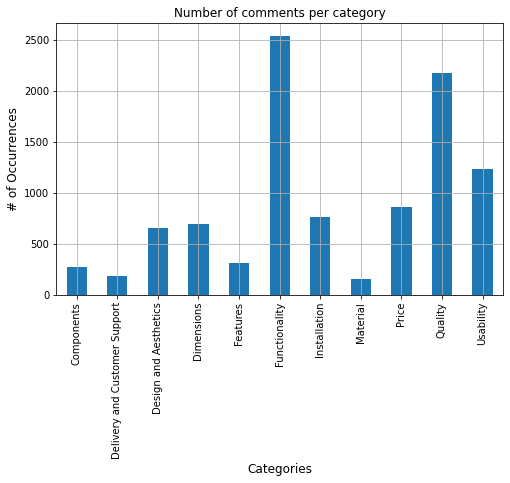

In [8]:
df_stats.plot(x='Cateogry', y='Review_Count', kind='bar', legend=False, grid=True, figsize=(8, 5))
plt.title("Number of comments per category")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Categories', fontsize=12)
plt.show()

#### <font color="green"> **2. Number of Reviews with Multi - Label ?**




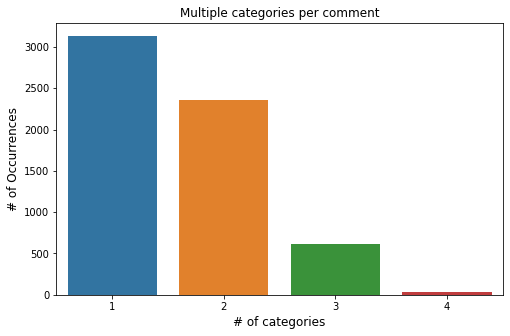

In [9]:
#exclude polarity
rowsums = df.iloc[:,2:-1].sum(axis=1)
x=rowsums.value_counts()

#plot
plt.figure(figsize=(8,5))
ax = sns.barplot(x.index, x.values)
plt.title("Multiple categories per comment")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of categories', fontsize=12)
plt.show()

#### <font color="green"> **3. Text Distribution in each Review**




Max Lettered Review :  1987


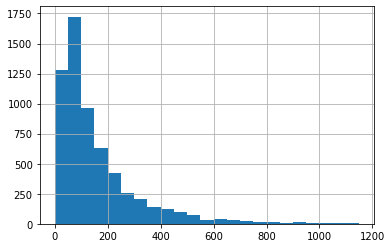

In [10]:
#Text Length distribution
textlen = df["Review"].str.len()

print("Max Lettered Review : ", max(textlen))

textlen.hist(bins = np.arange(0,1200,50))
plt.show()

Most reviews have letters between 50 - 100

Max Worded Review :  399


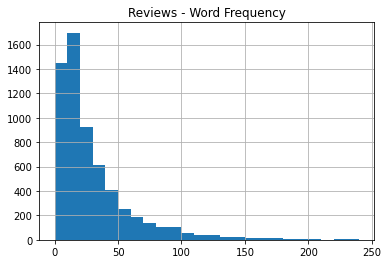

In [11]:
#Word Distribution
_sentences = df["Review"].str.split(" ")
wrd_cnt = []
for review in _sentences:
    wrd_cnt.append(len(review))

print("Max Worded Review : ", max(wrd_cnt))

wordlens = pd.DataFrame(wrd_cnt, columns=["Reviews - Word Frequency"])
wordlens.hist(bins = np.arange(0,250,10))
plt.show()

#### <font color="Purple"> **4. Data Processing**




In [12]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

In [13]:
# Clean the Reviews
df['Review'] = df['Review'].map(lambda com : clean_text(com))
test_df['Review'] = test_df['Review'].map(lambda com : clean_text(com))

In [14]:
test_df.head()

,Review
Id,
0,made of very thin cheap metal broke on very fi...
1,as good as the brand names no jams or misfires...
2,unit was easy to use with understandable in st...
3,i am the new family plumber works well no prob...
4,seems to be holding up well


#### <font color="Purple"> **5. Train Test Split**

In [15]:
# Set ID Column as the index
train_df = df.set_index('Id')

categories = ['Components',
 'Delivery and Customer Support',
 'Design and Aesthetics',
 'Dimensions',
 'Features',
 'Functionality',
 'Installation',
 'Material',
 'Price',
 'Quality',
 'Usability',
 'Polarity']

X = train_df['Review']
y = train_df[categories]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123, test_size=0.33, shuffle=True)

In [16]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4111,), (2025,), (4111, 12), (2025, 12))

#### <font color="Purple"> **6. Classifiers Description** </font><br>
**Pipeline** - Scikit-learn provides a pipeline utility to help automate machine learning workflows. Pipelines are very common in Machine Learning systems, since there is a lot of data to manipulate and many data transformations to apply. So we will utilize pipeline to train every classifier.

---


**OneVsRest multi-label strategy** - The Multi-label algorithm accepts a binary mask over multiple labels. The result for each prediction will be an array of 0s and 1s marking which class labels apply to each row input sample.

---


**Naive Bayes / Logistic / SVC** - OneVsRest strategy can be used for multi-label learning, where a classifier is used to predict multiple labels for instance. Naive Bayes supports multi-class, but we are in a multi-label scenario, therefore, we wrap Naive Bayes in the OneVsRestClassifier.

In [17]:
# Changing Test dataset to Series
test_sqz = test_df.squeeze()

#### <font color="Blue"> **7. Model : Logistic Regression Classifier** </font><br>


In [18]:
LogReg_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)),
                ])

In [19]:
LogReg_preds = pd.DataFrame(test_df)

for category in categories:
    print('... Processing {}'.format(category))
    # Training Model
    LogReg_pipeline.fit(X_train, y_train[category])
    # compute the testing accuracy
    prediction = LogReg_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(y_test[category], prediction)))

    # Predict on Test Dataset
    pred_test = LogReg_pipeline.predict(test_sqz)
    # Append the predictions
    LogReg_preds[category] = pred_test

... Processing Components
Test accuracy is 0.9535802469135802
... Processing Delivery and Customer Support
Test accuracy is 0.9708641975308642
... Processing Design and Aesthetics
Test accuracy is 0.9214814814814815
... Processing Dimensions
Test accuracy is 0.9249382716049382
... Processing Features
Test accuracy is 0.9476543209876543
... Processing Functionality
Test accuracy is 0.8469135802469135
... Processing Installation
Test accuracy is 0.9328395061728395
... Processing Material
Test accuracy is 0.9758024691358025
... Processing Price
Test accuracy is 0.9264197530864198
... Processing Quality
Test accuracy is 0.8671604938271605
... Processing Usability
Test accuracy is 0.8982716049382716
... Processing Polarity
Test accuracy is 0.8785185185185185


In [20]:
LogReg_preds.reset_index(drop=False, inplace=True)
#LogReg_preds.to_excel("LogReg_preds.xlsx", index=False)
submissions = LogReg_preds.iloc[:,2:]
submissions.to_excel("LogReg_submit.xlsx", index=False)

#### <font color="Blue"> **8. Model : Support Vector Classifier** </font><br>

In [21]:
SVC_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(LinearSVC(), n_jobs=1)),
                ])

In [22]:
SVC_preds = pd.DataFrame(test_df)

for category in categories:
    print('... Processing {}'.format(category))
    # Training Model
    SVC_pipeline.fit(X_train, y_train[category])
    # compute the testing accuracy
    prediction = SVC_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(y_test[category], prediction)))

    # Predict on Test Dataset
    pred_test = SVC_pipeline.predict(test_sqz)
    # Append the predictions
    SVC_preds[category] = pred_test

... Processing Components
Test accuracy is 0.957037037037037
... Processing Delivery and Customer Support
Test accuracy is 0.9822222222222222
... Processing Design and Aesthetics
Test accuracy is 0.9338271604938272
... Processing Dimensions
Test accuracy is 0.9412345679012346
... Processing Features
Test accuracy is 0.9545679012345679
... Processing Functionality
Test accuracy is 0.8434567901234568
... Processing Installation
Test accuracy is 0.9540740740740741
... Processing Material
Test accuracy is 0.9772839506172839
... Processing Price
Test accuracy is 0.951604938271605
... Processing Quality
Test accuracy is 0.868641975308642
... Processing Usability
Test accuracy is 0.9209876543209876
... Processing Polarity
Test accuracy is 0.8928395061728395


In [23]:
SVC_preds.reset_index(drop=True, inplace=True)
#LogReg_preds.to_excel("LogReg_preds.xlsx", index=False)
submissions = SVC_preds.iloc[:,2:]
submissions.to_excel("SVC_submit.xlsx", index=False)

#### <font color="Blue"> **9. Model : Naive Bayes Classifier** </font><br>

In [24]:
NB_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(MultinomialNB(), n_jobs=1)),
                ])

In [25]:
NB_preds = pd.DataFrame(test_df)

for category in categories:
    print('... Processing {}'.format(category))
    # Training Model
    NB_pipeline.fit(X_train, y_train[category])
    # compute the testing accuracy
    prediction = NB_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(y_test[category], prediction)))

    # Predict on Test Dataset
    pred_test = NB_pipeline.predict(test_sqz)
    # Append the predictions
    NB_preds[category] = pred_test

... Processing Components
Test accuracy is 0.9530864197530864
... Processing Delivery and Customer Support
Test accuracy is 0.9708641975308642
... Processing Design and Aesthetics
Test accuracy is 0.8928395061728395
... Processing Dimensions
Test accuracy is 0.8879012345679013
... Processing Features
Test accuracy is 0.9471604938271605
... Processing Functionality
Test accuracy is 0.797037037037037
... Processing Installation
Test accuracy is 0.8770370370370371
... Processing Material
Test accuracy is 0.9753086419753086
... Processing Price
Test accuracy is 0.8617283950617284
... Processing Quality
Test accuracy is 0.7585185185185185
... Processing Usability
Test accuracy is 0.8054320987654321
... Processing Polarity
Test accuracy is 0.8098765432098766


In [26]:
NB_preds.reset_index(drop=True, inplace=True)
#LogReg_preds.to_excel("LogReg_preds.xlsx", index=False)
submissions = NB_preds.iloc[:,2:]
submissions.to_excel("NB_submit.xlsx", index=False)

#### <font color="Blue"> **10. Model : Testing Other 1** </font><br>

In [ ]:
Pipeline10 = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words, min_df=10, max_features=1000)),
                ('clf', OneVsRestClassifier(LinearSVC(), n_jobs=1)),
                ])

In [ ]:
preds10 = pd.DataFrame(test_df)

for category in categories:
    print('... Processing {}'.format(category))
    # Training Model
    Pipeline10.fit(X_train, y_train[category])
    # compute the testing accuracy
    prediction = Pipeline10.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(y_test[category], prediction)))

    # Predict on Test Dataset
    pred_test = Pipeline10.predict(test_sqz)
    # Append the predictions
    preds10[category] = pred_test

... Processing Components
Test accuracy is 0.9555555555555556
... Processing Delivery and Customer Support
Test accuracy is 0.9807407407407407
... Processing Design and Aesthetics
Test accuracy is 0.9353086419753086
... Processing Dimensions
Test accuracy is 0.9422222222222222
... Processing Features
Test accuracy is 0.9496296296296296
... Processing Functionality
Test accuracy is 0.8306172839506173
... Processing Installation
Test accuracy is 0.9506172839506173
... Processing Material
Test accuracy is 0.9762962962962963
... Processing Price
Test accuracy is 0.9530864197530864
... Processing Quality
Test accuracy is 0.8676543209876543
... Processing Usability
Test accuracy is 0.9160493827160494
... Processing Polarity
Test accuracy is 0.8775308641975309


In [ ]:
preds10.reset_index(drop=True, inplace=True)
#LogReg_preds.to_excel("LogReg_preds.xlsx", index=False)
submissions = preds10.iloc[:,2:]
submissions.to_excel("preds10_submit.xlsx", index=False)